In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.ticker as mtick
import statsmodels.api as sm

In [2]:
base_path = os.path.join(os.getcwd(), '..', 'steam-insights-main')

games_df_path = os.path.join(base_path, 'games.csv')
reviews_path = os.path.join(base_path, 'reviews.csv')

In [3]:
# Read games.csv (only app_id and name) and drop rows with missing name
games = pd.read_csv(
    games_df_path,
    usecols=["app_id", "name", "release_date"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip'
)
games = games.dropna(subset=['name'])

# Read reviews.csv and drop rows with missing genre
reviews = pd.read_csv(
    reviews_path,
    usecols=["app_id", "review_score"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
print(reviews.dtypes)

# Print the number of 'N' or null values before dropping them
print("Number of 'N' or null values in review_score before dropping:", reviews['review_score'].isna().sum() + (reviews['review_score'] == 'N').sum())

# Convert review_score to numeric, forcing errors to NaN (this will turn 'N' into NaN)
reviews['review_score'] = pd.to_numeric(reviews['review_score'], errors='coerce')

# Drop rows where review_score is NaN (which includes former 'N' values)
reviews = reviews.dropna(subset=['review_score'])


app_id           int64
review_score    object
dtype: object
Number of 'N' or null values in review_score before dropping: 5


In [4]:
# Merge games and steamspy with an inner join so that only games present in both are kept
df_merged = pd.merge(games, reviews, on="app_id", how="inner")

display(df_merged.head())
print(f"Total rows in merged data: {df_merged.shape[0]}")

,app_id,name,release_date,review_score
0,10,Counter-Strike,2000-11-01,9.0
1,20,Team Fortress Classic,1999-04-01,8.0
2,30,Day of Defeat,2003-05-01,8.0
3,40,Deathmatch Classic,2001-06-01,8.0
4,50,Half-Life: Opposing Force,1999-11-01,9.0


Total rows in merged data: 140077


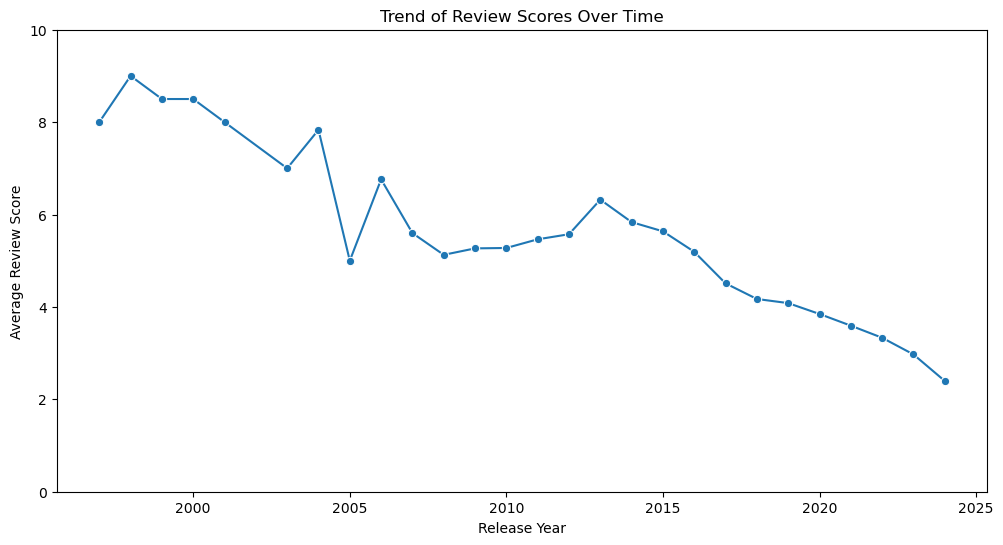

In [5]:
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

yearly_reviews = df_merged.groupby('release_year')['review_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='review_score', data=yearly_reviews, marker='o')
plt.xlabel("Release Year")
plt.ylabel("Average Review Score")
plt.title("Trend of Review Scores Over Time")
plt.ylim(0, 10)
plt.show()


# See how review scores have evolved over the years.


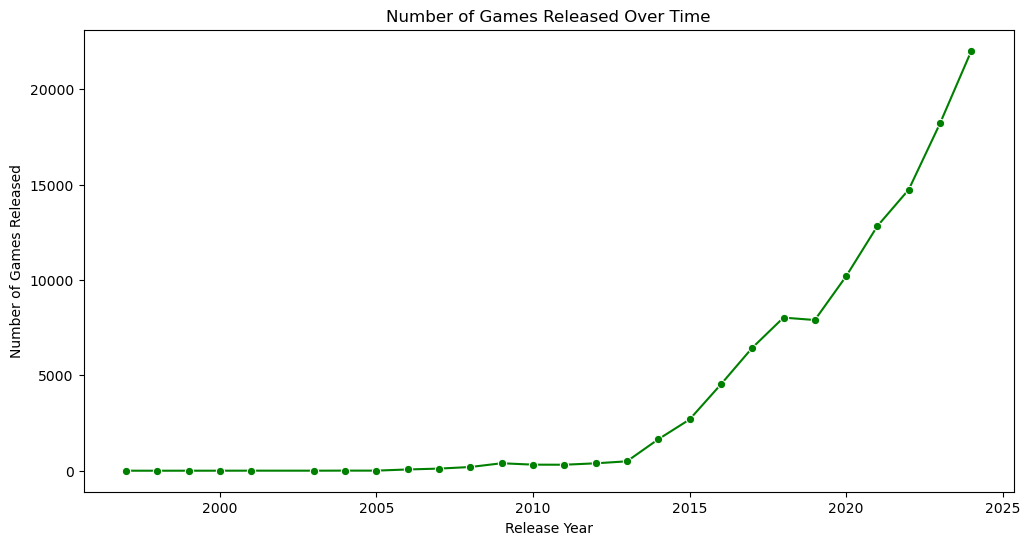

In [6]:
# Show the number of games released each year
# Maybe also show the number of games above and below the average review score for each year.
# Might work as a bar graph?

# x axis = year
# y axis = number of games
# stacked bar graph
# one stack is games with review score above average
# other stack is games with review score below average

# Count number of games released each year
yearly_game_counts = df_merged.groupby('release_year').size().reset_index(name='num_games')

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='num_games', data=yearly_game_counts, marker='o', color='green')
plt.xlabel("Release Year")
plt.ylabel("Number of Games Released")
plt.title("Number of Games Released Over Time")
plt.show()





Average Review Score for all games: 3.56


<Figure size 1200x600 with 0 Axes>

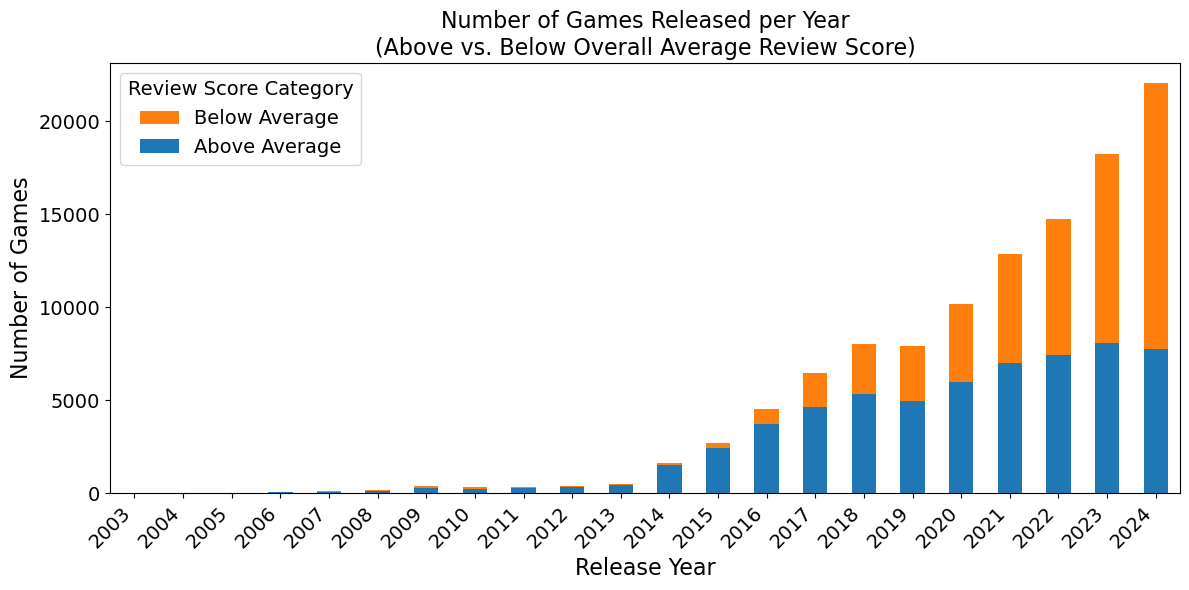

In [7]:
# Assume df_merged already has the 'review_score' and 'release_date' columns
# Convert release_date to datetime and drop invalid ones
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

df_merged = df_merged[df_merged['release_year'] >= 2003]

# Calculate the overall average review score
avg_review = df_merged['review_score'].mean()
print(f"Average Review Score for all games: {avg_review:.2f}")

# Categorize games based on the average review score
df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')

# Group by release_year and score_category and count the number of games
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')

# Modify the pivot table creation to ensure consistent order
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot[['Above Average', 'Below Average']]  # Explicitly set column order
yearly_pivot = yearly_pivot.sort_index()


# Plot a stacked bar graph
plt.figure(figsize=(12, 6))
ax = yearly_pivot.plot(kind='bar', stacked=True, figsize=(12,6))

# Font size parameters
TITLE_FONTSIZE = 16
XLABEL_FONTSIZE = 16
YLABEL_FONTSIZE = 16
XTICKLABEL_FONTSIZE = 14
YTICKLABEL_FONTSIZE = 14
LEGEND_TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 14

plt.xlabel("Release Year", fontsize=XLABEL_FONTSIZE)
plt.ylabel("Number of Games", fontsize=YLABEL_FONTSIZE)
plt.title("Number of Games Released per Year\n(Above vs. Below Overall Average Review Score)", fontsize=TITLE_FONTSIZE)

# Explicitly control legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Review Score Category", 
          title_fontsize=LEGEND_TITLE_FONTSIZE, fontsize=LEGEND_FONTSIZE)

plt.xticks(rotation=45, ha='right', fontsize=XTICKLABEL_FONTSIZE)
plt.yticks(fontsize=YTICKLABEL_FONTSIZE)
plt.savefig('bar1.pdf', format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [8]:
# put a line with the ratio between above and below average for each year over this graph
# pearsons between ratio and the ammount of games release that year

In [9]:
# Label each game
df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')

# Group by release year and score category
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')

# Pivot for a stacked bar plot
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot.sort_index()

display(yearly_pivot.head(30))



score_category,Above Average,Below Average
release_year,,
2003,3.0,0.0
2004,6.0,0.0
2005,4.0,2.0
2006,61.0,6.0
2007,88.0,24.0
2008,145.0,51.0
2009,309.0,84.0
2010,253.0,66.0
2011,262.0,53.0


<Figure size 1200x600 with 0 Axes>

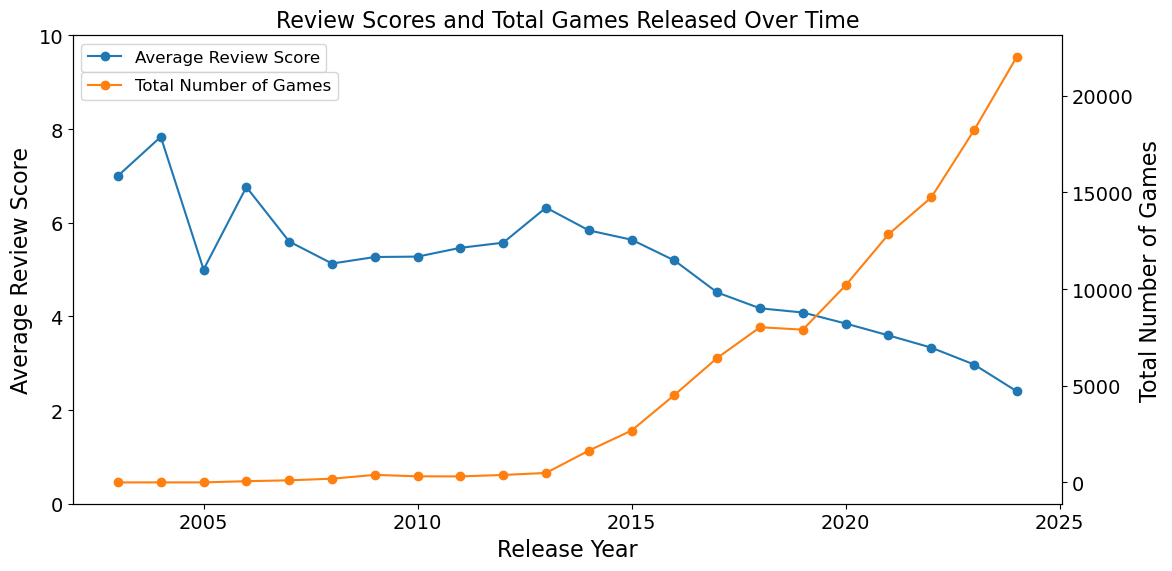

In [10]:
# Average review score per year
yearly_reviews = df_merged.groupby('release_year')['review_score'].mean().reset_index()
total_games = df_merged.groupby('release_year').size().reset_index(name='total_games')

plt.figure(figsize=(12, 6))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Increase font sizes
plt.rcParams.update({'font.size': 16})  # Base font size
plt.title("Review Scores and Total Games Released Over Time", fontsize=16)

# Plot average review score on primary y-axis
ax1.set_xlabel("Release Year", fontsize=16)
ax1.set_ylabel("Average Review Score", color='black', fontsize=16)
ax1.plot(yearly_reviews['release_year'], yearly_reviews['review_score'], marker='o', color='#1f77b4', label="Average Review Score")
ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.set_ylim(0, 10)

# Create a secondary y-axis for total number of games
ax2 = ax1.twinx()
ax2.set_ylabel("Total Number of Games", color='black', fontsize=16)
ax2.plot(total_games['release_year'], total_games['total_games'], marker='o', color='#ff7f0f', label="Total Number of Games")
ax2.tick_params(axis='y', labelcolor='black', labelsize=14)

# Add legends with larger font
ax1.legend(fontsize=12, loc='upper left')
ax2.legend(fontsize=12, loc='upper left', bbox_to_anchor=(0, 0.94))

fig.tight_layout()

plt.savefig('doubleLine.pdf', format='pdf', bbox_inches='tight')

plt.show()

# Price vs. Review Trend:
# As you noted, recent years show a 50/50 split of games above and below the overall average review score.
# This may indicate market saturation with lower-quality games impacting the overall review average.

# Release Volume:
# The dramatic increase in the number of games (from fewer than 2000 to over 11,000 per year) 
# might be contributing to the drop in average review scores if many new games have lower ratings.


In [11]:
# Filter historical data for release years from 2003 onward
total_games_2003 = total_games[total_games['release_year'] >= 2003].copy()

# Prepare the feature and target arrays using the filtered data
X = total_games_2003['release_year'].values.reshape(-1, 1)  # Independent variable: release year
y = total_games_2003['total_games'].values                 # Dependent variable: total games

# Fit the linear regression model on data from 2003 onward
lin_reg = LinearRegression().fit(X, y)
print("Coefficient:", lin_reg.coef_[0])
print("Intercept:", lin_reg.intercept_)

# Predict for future years, e.g., 2024 to 2029
future_years = np.array([2024, 2025, 2026, 2027, 2028, 2029]).reshape(-1, 1)
future_predictions = lin_reg.predict(future_years)
forecast_df = pd.DataFrame({'release_year': future_years.flatten(), 'predicted_total_games': future_predictions})
print(forecast_df)

# Combine historical years (from 2003 onward) with future years
all_years = np.concatenate([total_games_2003['release_year'].values, future_years.flatten()])
all_years = np.sort(all_years)

# Predict for the extended range of years
all_predictions = lin_reg.predict(all_years.reshape(-1, 1))


Coefficient: 907.3845285149633
Intercept: -1821948.3845285152
   release_year  predicted_total_games
0          2024           14597.901186
1          2025           15505.285714
2          2026           16412.670243
3          2027           17320.054771
4          2028           18227.439300
5          2029           19134.823828


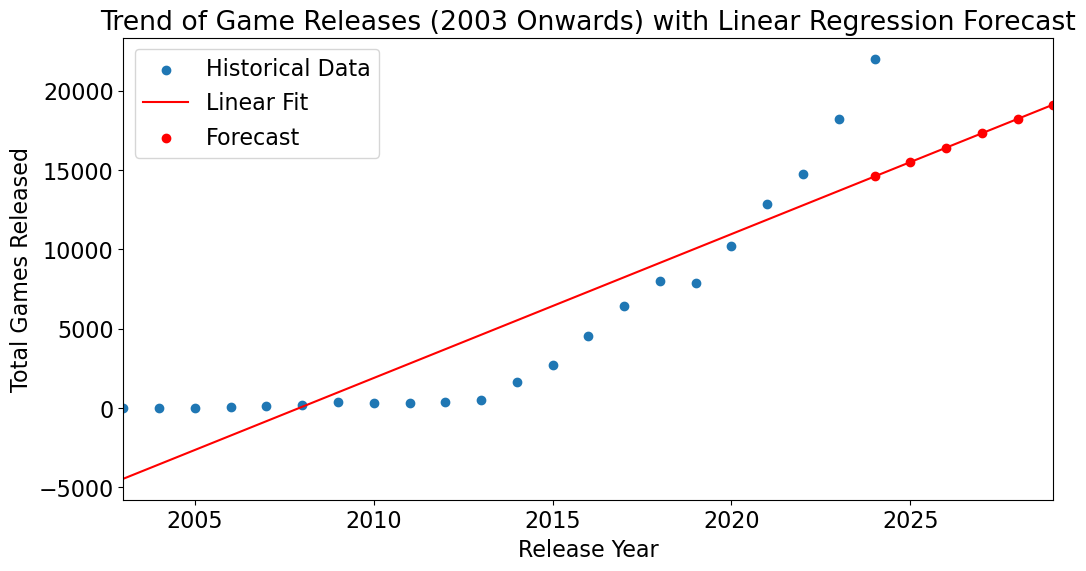

In [12]:

# Plot the historical data and extended regression line with forecasts
plt.figure(figsize=(12, 6))
plt.scatter(total_games_2003['release_year'], total_games_2003['total_games'], label='Historical Data')
plt.plot(all_years, all_predictions, color='red', label='Linear Fit')
plt.scatter(forecast_df['release_year'], forecast_df['predicted_total_games'], marker='o', color='red', label='Forecast')
plt.xlabel('Release Year')
plt.ylabel('Total Games Released')
plt.title('Trend of Game Releases (2003 Onwards) with Linear Regression Forecast')
plt.xlim(2003, 2029)
plt.legend()
plt.show()

In [13]:
# --- Step 1: Filter Data from 2003 Onwards and Aggregate ---
total_games_2003 = total_games[total_games['release_year'] >= 2003].copy()

# Set release_year as index for time series modeling (aggregated series)
total_games_ts = total_games_2003.set_index('release_year')['total_games']

                               SARIMAX Results                                
Dep. Variable:            total_games   No. Observations:                   22
Model:                ARIMA(10, 1, 2)   Log Likelihood                -280.337
Date:                Thu, 27 Mar 2025   AIC                            586.674
Time:                        23:15:27   BIC                            600.253
Sample:                             0   HQIC                           589.621
                                 - 22                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2340      0.024     -9.578      0.000      -0.282      -0.186
ar.L2          0.0868      0.021      4.210      0.000       0.046       0.127
ar.L3          0.8221      0.020     40.531      0.0

/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base

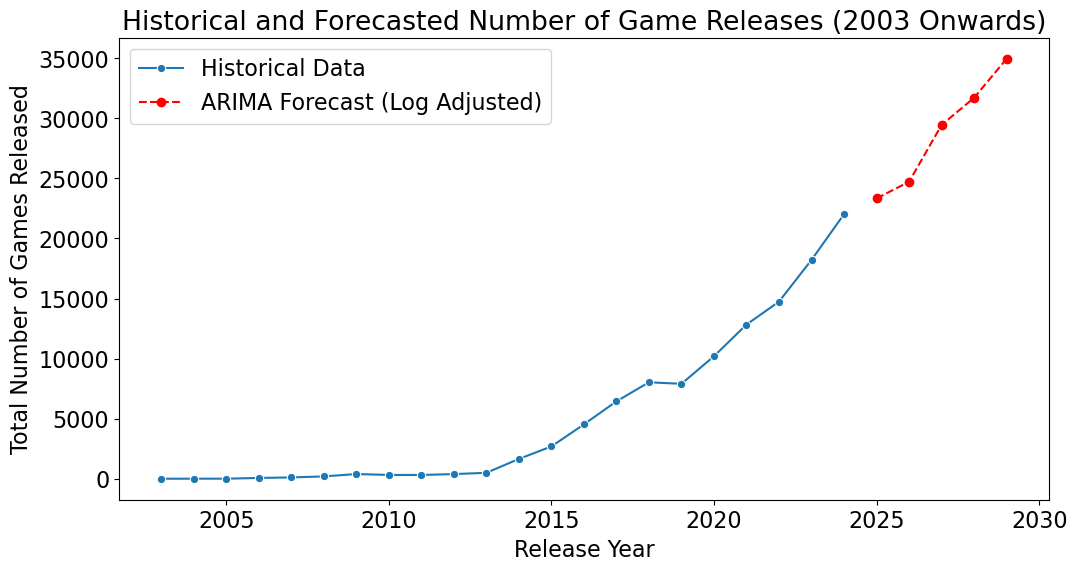

In [14]:
# --- Step 2: Fit ARIMA Model for Aggregated Total ---
# Experiment with ARIMA orders; here we use (10, 1, 2) as an example
model_total = sm.tsa.ARIMA(total_games_ts, order=(10, 1, 2))
model_total_fit = model_total.fit()
print(model_total_fit.summary())

forecast_steps = 5
forecast_total = model_total_fit.forecast(steps=forecast_steps)
forecast_years = np.arange(total_games_ts.index.max() + 1, total_games_ts.index.max() + forecast_steps + 1)
aggregated_forecast_df = pd.DataFrame({
    'release_year': forecast_years,
    'predicted_total_games': forecast_total
})
print("Aggregated Forecast:")
print(aggregated_forecast_df)


# Plot historical data and adjusted ARIMA forecast
plt.figure(figsize=(12, 6))
sns.lineplot(x=total_games_2003['release_year'], y=total_games_2003['total_games'], marker='o', label='Historical Data')
plt.plot(aggregated_forecast_df['release_year'], aggregated_forecast_df['predicted_total_games'], marker='o', linestyle='--', color='red', label='ARIMA Forecast (Log Adjusted)')
plt.xlabel("Release Year")
plt.ylabel("Total Number of Games Released")
plt.title("Historical and Forecasted Number of Game Releases (2003 Onwards)")
plt.legend()
plt.show()

In [15]:
# --- Step 3: Prepare Historical Stacked Data ---
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot.sort_index()
print("Historical stacked counts:")
print(yearly_pivot)

Historical stacked counts:
score_category  Above Average  Below Average
release_year                                
2003                      3.0            0.0
2004                      6.0            0.0
2005                      4.0            2.0
2006                     61.0            6.0
2007                     88.0           24.0
2008                    145.0           51.0
2009                    309.0           84.0
2010                    253.0           66.0
2011                    262.0           53.0
2012                    323.0           66.0
2013                    470.0           24.0
2014                   1531.0          118.0
2015                   2430.0          258.0
2016                   3745.0          782.0
2017                   4640.0         1802.0
2018                   5353.0         2676.0
2019                   4982.0         2920.0
2020                   5957.0         4240.0
2021                   7000.0         5833.0
2022                   7425.

In [16]:
# --- Step 4: Fit ARIMA Models for Each Category (Segmented Forecasts) ---
future_steps = 5
last_year = yearly_pivot.index.max()
future_years = np.arange(last_year + 1, last_year + 1 + future_steps)

# Extract time series for each category
above_ts = yearly_pivot['Above Average']
below_ts = yearly_pivot['Below Average']

# Fit ARIMA for Above Average (example order: (5,1,1))
model_above = sm.tsa.ARIMA(above_ts, order=(8,1,1))
model_above_fit = model_above.fit()
forecast_above = model_above_fit.forecast(steps=future_steps)

# Fit ARIMA for Below Average (example order: (5,1,1))
model_below = sm.tsa.ARIMA(below_ts, order=(5,1,1))
model_below_fit = model_below.fit()
forecast_below = model_below_fit.forecast(steps=future_steps)

/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/fds-cw2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base

In [17]:

# Convert forecast series to numpy arrays
forecast_above_arr = np.array(forecast_above)
forecast_below_arr = np.array(forecast_below)

adjusted_forecast_above = []
adjusted_forecast_below = []
for i in range(forecast_steps):
    seg_sum = forecast_above_arr[i] + forecast_below_arr[i]
    if seg_sum == 0:
        factor = 0
    else:
        factor = aggregated_forecast_df.iloc[i]['predicted_total_games'] / seg_sum
    adjusted_forecast_above.append(forecast_above_arr[i] * factor)
    adjusted_forecast_below.append(forecast_below_arr[i] * factor)

# Build forecast DataFrame for segmented series after adjustment
forecast_seg_df = pd.DataFrame({
    'release_year': future_years,
    'predicted_above': adjusted_forecast_above,
    'predicted_below': adjusted_forecast_below
})
forecast_seg_df['total_predicted'] = forecast_seg_df['predicted_above'] + forecast_seg_df['predicted_below']
forecast_seg_df['pct_above'] = (forecast_seg_df['predicted_above'] / forecast_seg_df['total_predicted']) * 100
forecast_seg_df['pct_below'] = (forecast_seg_df['predicted_below'] / forecast_seg_df['total_predicted']) * 100

print("\nAdjusted Forecasted Counts and Percentages:")
print(forecast_seg_df)



Adjusted Forecasted Counts and Percentages:
   release_year  predicted_above  predicted_below  total_predicted  pct_above  \
0          2025      6592.169578     16741.920262     23334.089840  28.251239   
1          2026      5697.048618     19021.270247     24718.318864  23.047881   
2          2027      5905.815686     23540.526358     29446.342045  20.056195   
3          2028      5338.959839     26370.852022     31709.811861  16.836933   
4          2029      5148.580293     29811.039390     34959.619683  14.727221   

   pct_below  
0  71.748761  
1  76.952119  
2  79.943805  
3  83.163067  
4  85.272779  


<Figure size 1400x700 with 0 Axes>

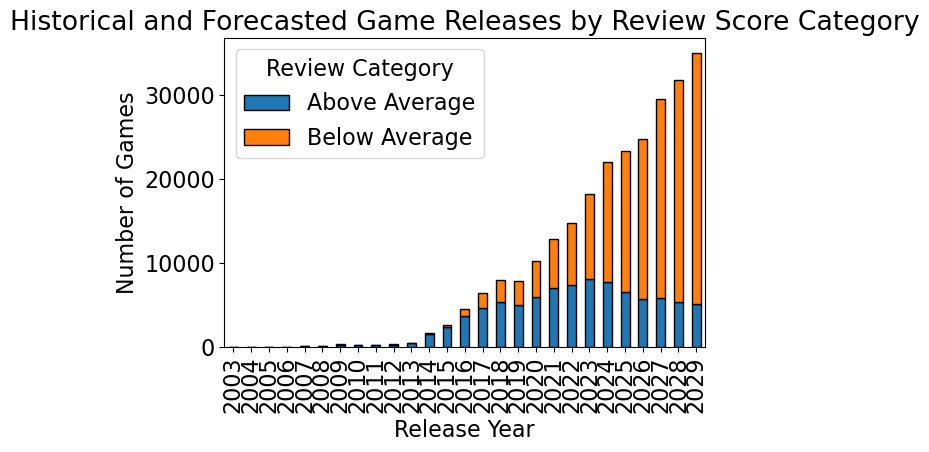

In [18]:
# --- Step 6: Combine Historical and Adjusted Forecasts ---
# Rename forecast columns to match historical data
future_df = forecast_seg_df.copy().set_index('release_year')[['predicted_above', 'predicted_below']]
future_df.columns = ['Above Average', 'Below Average']

# Combine with historical stacked data
combined_df = pd.concat([yearly_pivot, future_df]).sort_index()

# Filter combined_df to include only years from 2003 to 2029
combined_df_filtered = combined_df[(combined_df.index >= 2003) & (combined_df.index <= 2029)]

# Plot a stacked bar chart for combined filtered data
plt.figure(figsize=(14,7))
combined_df_filtered.plot(kind='bar', stacked=True, edgecolor='black')
plt.xlabel("Release Year")
plt.ylabel("Number of Games")
plt.title("Historical and Forecasted Game Releases by Review Score Category")
plt.legend(title='Review Category')
plt.tight_layout()
plt.show()


In [ ]:
print(combined_df_filtered.tail())


In [ ]:
# Graph to use:
# Trend over time (line graph): average review score with no. games release per year
# Stacked bar graph of game releases by quantity of review score above/below average
# Arima forecast with comparison to linear regression

In [ ]:
# Group by year and count total games
total_games_per_year = df_merged.groupby('release_year').size().rename('total_games')

# Calculate overall average review score
avg_review = df_merged['review_score'].mean()

# Calculate count of above-average games per year
above_avg_per_year = df_merged[df_merged['review_score'] >= avg_review].groupby('release_year').size().rename('above_avg_games')

# Merge into a single DataFrame and fill missing values with 0
yearly_data = pd.DataFrame({'total_games': total_games_per_year, 'above_avg_games': above_avg_per_year}).fillna(0)

# Calculate proportion of above-average games
yearly_data['prop_above'] = yearly_data['above_avg_games'] / yearly_data['total_games']

# Filter for years from 2003 onward
yearly_data = yearly_data[yearly_data.index >= 2003].reset_index()

# Run the OLS regression: total_games as predictor, prop_above as response
X = sm.add_constant(yearly_data['total_games'])
model = sm.OLS(yearly_data['prop_above'], X).fit()
print(model.summary())
